In [12]:
from inference_script import DetectionAnalysis
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# results_file = Path("/lustre/home/barmstrong/ssm_bench/outputs/singlerun/2025-10-02/11-16-20/ca62/test_outputs") / "test_outputs.npz"
results_file = Path("/lustre/home/barmstrong/ssm_bench/outputs/singlerun/2025-09-30/15-34-28/e0e2/test_outputs") / "test_outputs.npz"
# results_file = Path("../results/benedict/v2z6t9wz.csv")

# check extension
if results_file.suffix == ".csv":
    df = pd.read_csv(results_file)
else:
    data = np.load(results_file)

    print(list(data.keys()))

    # load data["targets_0"] (N, ) and data["outputs_0"] (N, 2) into df
    df = pd.DataFrame({
        "y_true": data["targets_0"],
        "y_score": data["outputs_0"][:, 1],
        "snr": data["snr"][:, 0],
        "correct": data["targets_0"] == np.argmax(data["outputs_0"], axis=1)
    })

df

['inputs', 'chi1', 'chi2', 'chirp_mass', 'dec', 'distance', 'inclination', 'labels', 'mass_1', 'mass_2', 'mass_ratio', 'phi', 'phic', 'psi', 's1z', 's2z', 'snr', 'outputs_0', 'targets_0', 'outputs_1', 'targets_1', 'outputs_2', 'targets_2']


,y_true,y_score,snr,correct
0,0,-5.913749e+00,0.000000,True
1,1,-1.192093e-07,29.373680,True
2,1,-1.192093e-07,28.873734,True
3,1,-3.337855e-06,23.783968,True
4,0,-6.472267e+00,0.000000,True
...,...,...,...,...
20015,1,-1.129047e-02,23.855408,True
20016,0,-5.767156e+00,0.000000,True
20017,1,0.000000e+00,53.145969,True
20018,0,-6.733797e+00,0.000000,True


In [14]:
# print absolute accuracy
print(f"Accuracy over test set: {df['correct'].mean():.2%}")

Accuracy over test set: 98.05%


In [15]:
# get samples where snr is between 0 and 10 (These seem to be errors in the dataset)
# TODO: Investigate why these samples exist?
df_snr_0_10 = df[(df["snr"] > 0) & (df["snr"] <= 10)]
df_snr_0_10

# remove these samples
df = df[~((df["snr"] > 0) & (df["snr"] <= 10))]
print(f"Number of samples after removing: {len(df)}, removed {len(df_snr_0_10)} samples")

Number of samples after removing: 19997, removed 23 samples


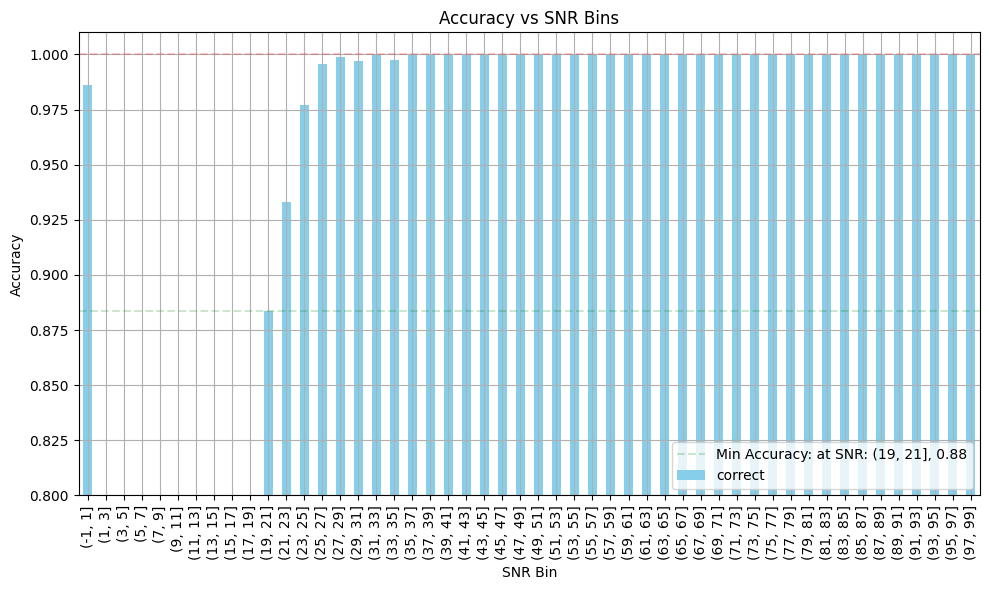

In [16]:
# accuracy vs SNR bins
# bins = np.arange(0, df["snr"].max()+1, 1)
bins = np.arange(-1, 100, 2)
acc_by_bin = df.assign(snr_bin=pd.cut(df["snr"], bins=bins)).groupby("snr_bin", observed=False)["correct"].mean()

# plot accuracy vs SNR bins (show only > 0.5)
plt.figure(figsize=(10, 6))
acc_by_bin.plot(kind='bar', color='skyblue')
plt.axhline(y=1, color='red', linestyle='--', alpha=0.2)

# line at min accuracy
plt.axhline(y=acc_by_bin.min(), color='green', linestyle='--', alpha=0.2, label=f'Min Accuracy: at SNR: {acc_by_bin.idxmin()}, {acc_by_bin.min():.2f}')

plt.title('Accuracy vs SNR Bins')
plt.xlabel('SNR Bin')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.01)
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

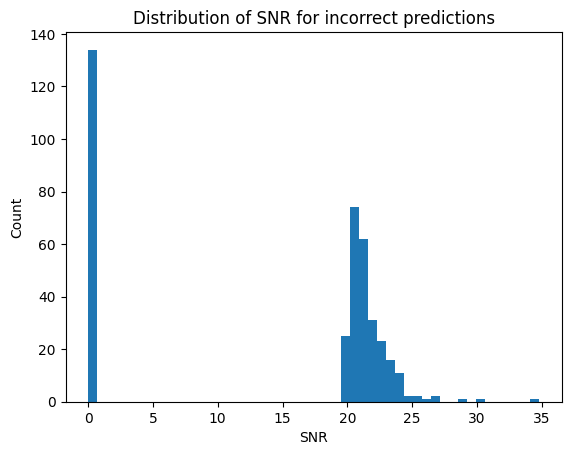

In [17]:
# plot distribution of snr for incorrect
plt.hist(df[~df["correct"]]["snr"], bins=50)
plt.xlabel("SNR")
plt.ylabel("Count")
plt.title("Distribution of SNR for incorrect predictions")
plt.show()

In [18]:
analysis = DetectionAnalysis(df["snr"], df["y_true"], df["y_score"])

In [19]:
fpr, tpr, roc_auc = analysis.compute_roc()
print(f"ROC AUC: {roc_auc}")


ROC AUC: 0.9972417644360885


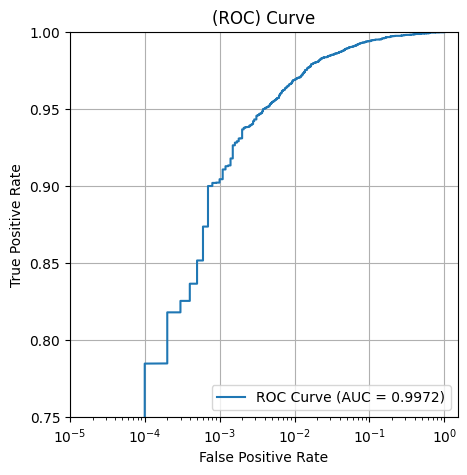

In [20]:
# plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve')


plt.ylim(0.75, 1.)
plt.xlim(1e-5, 1.5)
plt.xscale('log')
plt.legend()
plt.grid()

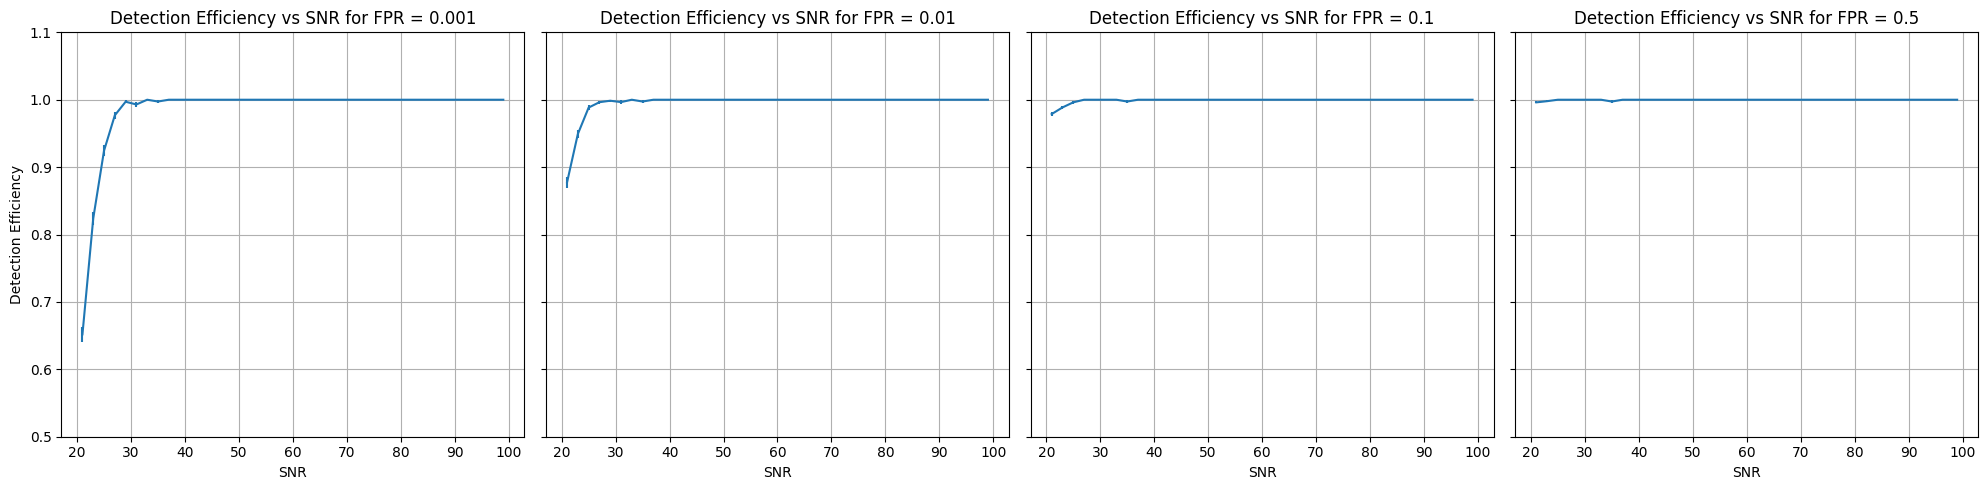

In [29]:
fprs = [0.001, 0.01, 0.1, 0.5]

fig, axes = plt.subplots(ncols=len(fprs), figsize=(5*len(fprs), 5), sharey=True)

for i, (fpr, ax) in enumerate(zip(fprs, axes)):
    bin_centers, efficiency, errors = analysis.compute_efficiency(fpr)
    ax.errorbar(bin_centers, efficiency, yerr=errors, fmt='-', label='Efficiency')
    ax.set_xlabel('SNR')
    ax.grid()
    ax.set_title(f'Detection Efficiency vs SNR for FPR = {fpr}')

# shared y-axis
axes[0].set_ylim(0.5, 1.1)
axes[0].set_ylabel('Detection Efficiency')

plt.tight_layout()
plt.show()
